In [37]:
import pickle
import re
import os

import random
import numpy as np
import torch
from random import shuffle
import argparse
import pickle

import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math

In [72]:
def rand_tansor(r1, r2):
    return torch.linspace(r1, r2, 1000, requires_grad=True)

In [73]:
x = rand_tansor(r1=-5, r2=5)

In [74]:
def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [75]:
gelu_y = gelu(x)
tanh_y = nn.Tanh()(x)
relu_y = nn.ReLU()(x)

In [125]:
def act_func_plot(x, ys, ylabel="activation"):
    # x, y suppose to be tensor, so we need to deserialize them.
    x = x.data.detach().numpy().tolist()
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = "black"
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.rcParams["font.family"] = "Times New Roman"
    color_m = {"GeLU": "r", "TanH": "g", "ReLU": "b"}
    for key in ys.keys():
        label = key
        y = ys[label]
        y = y.data.detach().numpy().tolist()
        plt.plot(x, y, c=color_m[label], label=key, alpha=0.8)
    plt.tight_layout()
    plt.grid(color='black', linestyle='-.')
    plt.xlabel("input", fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

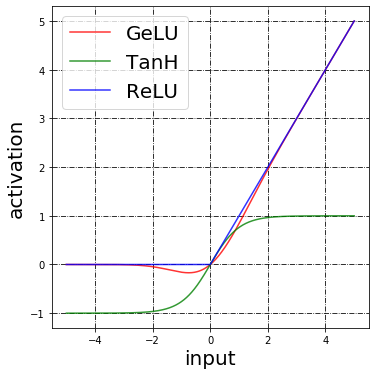

In [126]:
act_func_plot(x, {"GeLU": gelu_y, "TanH": tanh_y, "ReLU": relu_y})

In [127]:
gelu_y_grad = torch.autograd.grad(gelu_y, x, grad_outputs=torch.ones(gelu_y.shape), retain_graph=True)[0]
tanh_y_grad = torch.autograd.grad(tanh_y, x, grad_outputs=torch.ones(tanh_y.shape), retain_graph=True)[0]
relu_y_grad = torch.autograd.grad(relu_y, x, grad_outputs=torch.ones(relu_y.shape), retain_graph=True)[0]

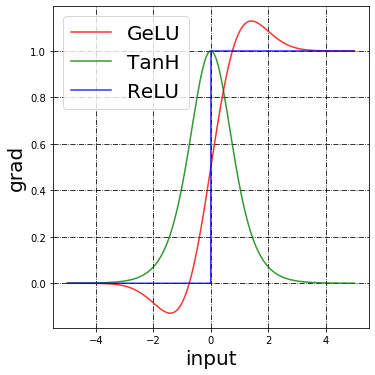

In [128]:
act_func_plot(x, {"GeLU": gelu_y_grad, "TanH": tanh_y_grad, "ReLU": relu_y_grad}, ylabel="grad")

#### Word deletion plot

In [4]:
import json
import pandas as pd
from typing import NoReturn
import os.path

In [8]:
word_deletion_tsv_path = "~/Downloads/word-deletion-correct.tsv"

In [9]:
word_deletion_df = pd.read_csv(word_deletion_tsv_path, sep="\t")

In [10]:
word_deletion_df

,SST-5-r,SST-5-gs,SST-5-gi,SST-5-lrp,SST-5-lat,SemEval-r,SemEval-gs,SemEval-gi,SemEval-lrp,SemEval-lat,IMDb-r,IMDb-gs,IMDb-gi,IMDb-lrp,IMDb-lat,Yelp-r,Yelp-gs,Yelp-gi,Yelp-lrp,Yelp-lat
0,0.93,0.72,0.71,0.72,0.96,0.96,0.83,0.84,0.84,0.97,0.99,0.97,0.97,0.96,0.99,0.98,0.87,0.88,0.91,0.99
1,0.83,0.61,0.61,0.60,0.89,0.94,0.77,0.77,0.77,0.96,0.99,0.95,0.95,0.94,0.99,0.97,0.83,0.82,0.86,0.96
2,0.78,0.53,0.53,0.52,0.82,0.90,0.71,0.72,0.71,0.94,0.99,0.93,0.94,0.92,0.98,0.95,0.79,0.79,0.83,0.95
3,0.65,0.45,0.44,0.45,0.74,0.86,0.67,0.67,0.66,0.91,0.98,0.92,0.91,0.92,0.98,0.93,0.75,0.76,0.81,0.93
4,0.61,0.38,0.39,0.38,0.66,0.85,0.63,0.64,0.61,0.86,0.99,0.92,0.92,0.90,0.98,0.92,0.75,0.75,0.78,0.92
5,0.56,0.31,0.32,0.32,0.59,0.82,0.58,0.58,0.57,0.81,0.98,0.92,0.92,0.89,0.97,0.88,0.71,0.72,0.77,0.90
6,0.51,0.28,0.27,0.30,0.52,0.76,0.54,0.55,0.54,0.77,0.97,0.90,0.91,0.88,0.96,0.89,0.70,0.70,0.74,0.88
7,0.49,0.25,0.24,0.25,0.47,0.74,0.53,0.53,0.52,0.72,0.97,0.89,0.90,0.88,0.95,0.88,0.68,0.68,0.71,0.87
8,0.41,0.23,0.24,0.24,0.40,0.72,0.52,0.52,0.50,0.67,0.96,0.88,0.89,0.87,0.94,0.86,0.65,0.66,0.69,0.85
9,0.39,0.24,0.23,0.25,0.35,0.66,0.51,0.51,0.50,0.63,0.95,0.87,0.87,0.87,0.94,0.83,0.64,0.66,0.68,0.83


In [78]:
def plot_word_deletion(word_deletion_df):
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    plt.style.use('ggplot')
    plt.style.use("default")
    font = {'family' : 'Times New Roman',
            'size'   : 30}
    plt.rc('font', **font)
    
    fig = plt.figure(figsize=(32, 8))
    
    labels = ["SST-5", "SemEval", "IMDb", "Yelp-5"]
    col_label = ["SST-5", "SemEval", "IMDb", "Yelp"]
    x_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"]
    x_ticks = [i for i in range(0, 11)]
    y_labels = ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
    y_ticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    for i in range(0, 4):
        ax = fig.add_subplot(1, 4, i+1)
        # this maps to negative, postive and neutral plots
        r_li = [1.00] + [float(e) for e in word_deletion_df[col_label[i]+"-r"]]
        gs_li = [1.00] + [float(e) for e in word_deletion_df[col_label[i]+"-gs"]]
        gi_li = [1.00] + [float(e) for e in word_deletion_df[col_label[i]+"-gi"]]
        lrp_li = [1.00] + [float(e) for e in word_deletion_df[col_label[i]+"-lrp"]]
        lat_li  = [1.00] + [float(e) for e in word_deletion_df[col_label[i]+"-lat"]]

        plt.plot(x_ticks, r_li, "--", label='Random', linewidth=5.0, markersize=15, alpha=0.7)
        plt.plot(x_ticks, gs_li, "--", label='GS', linewidth=5.0, marker="D", markersize=15, alpha=0.7)
        plt.plot(x_ticks, gi_li, "--", label='GI', linewidth=5.0, marker="s", markersize=15, alpha=0.7)
        plt.plot(x_ticks, lrp_li, "--", label='LRP', linewidth=5.0, marker="^", markersize=15, alpha=0.7)
        plt.plot(x_ticks, lat_li, "--", label='LAT', linewidth=5.0, marker="o", markersize=15, alpha=0.7)
        plt.grid(True)
        plt.grid(color='grey', linestyle='-.')
        plt.xticks(x_ticks, x_labels, fontsize=20)
        plt.yticks(y_ticks, y_labels, fontsize=20)
        if i >= 2:
            if i == 2:
                plt.ylim(0.5, 1.0)
            else:
                plt.ylim(0.5, 1.0)
            plt.text(3.5, 1.175, labels[i], fontsize=35)
        else:
            plt.ylim(0.0, 1.0)
            plt.text(3.5, 1.35, labels[i], fontsize=35)
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=2, fancybox=True, shadow=True)
        plt.xlabel("Number of words deleted")
        plt.ylabel("Accuracy (835 Sentences)")
        
    plt.show()

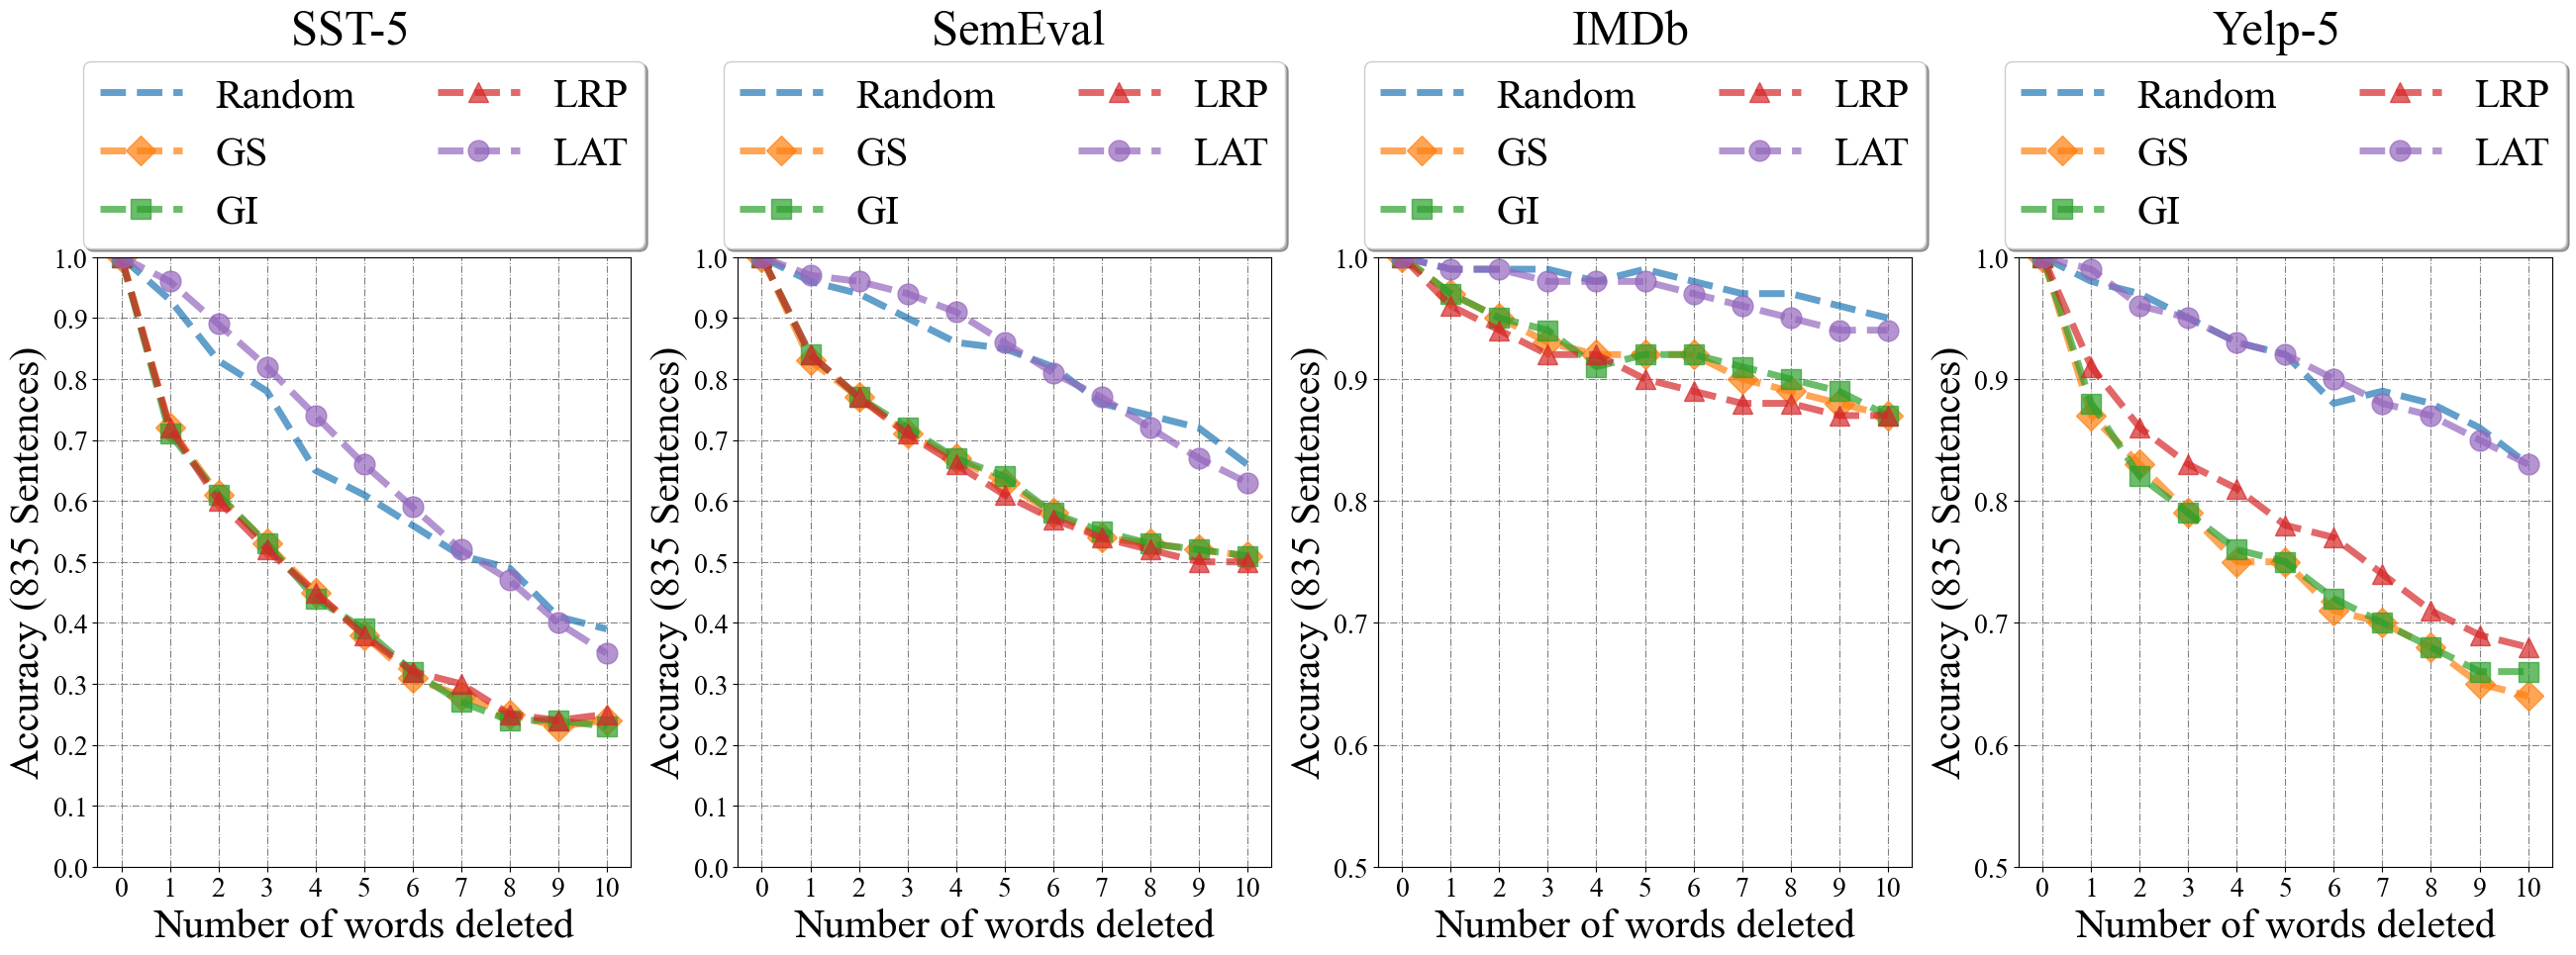

In [79]:
plot_word_deletion(word_deletion_df)